<a href="https://colab.research.google.com/github/roberth2018/Quantum-Machine-Learning/blob/main/Quantum_Machine_Learning_Model_Predictor_for_Continuous_Variable_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***QUANTUM MACHINE LEARNING MODEL PREDICTOR FOR CONTINUOUS VARIABLE***

By Roberth Saénz Pérez Alvarado , roberthspa@gmail.com




According to this paper: "Predicting toxicity by quantum machine learning" (Teppei Suzuki, Michio Katouda 2020) https://arxiv.org/abs/2008.07715 is possible to predict continuous variables using 2 qbits per feature applying encodings, variational circuits and some lineal transformations on expected values in order to predict values close to real target. 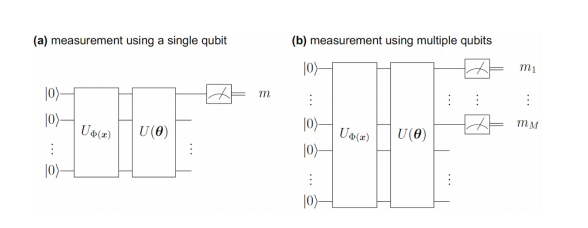 

Image from: https://arxiv.org/ftp/arxiv/papers/2008/2008.07715.pdf 
I uploaded the following example from https://pennylane.ai/qml/demos/quantum_neural_net using PennyLane libraries, a short dataset which consist on 1 variable input and 1 output, so that the processing does not take too much time.

In [ ]:
pip install numba==0.49.1

In [ ]:
pip install tensornetwork==0.3

In [ ]:
!pip install pennylane pennylane-sf 
import pennylane
dev = pennylane.device('default.qubit', wires=2)

In [8]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

With dataset from https://pennylane.ai/qml/demos/quantum_neural_net.html for evaluating if the algorithm can capture the nonlineality of this data.

In [32]:
data = np.loadtxt("sine.txt")

print(data.shape)

X = data[:, 0]

Y = data[:, 1]

(50, 2)


For encoding data, the autors (Teppei Suzuki, Michio Katouda 2020) use qbits rotations followed by 2 qbits entangled states in the form: U(x)-CNOT-U(x)-CNOT.


In [12]:
def statepreparation(x, nqbits):

    qml.RY(x, wires=[0])
    qml.RZ(x, wires=[0])
    qml.RY(x, wires=[1])
    qml.RZ(x, wires=[1])
    
    for q in range(nqbits-1):
        qml.CNOT(wires=[q, q+1])
    
    qml.RY(x, wires=[0])
    qml.RZ(x, wires=[0])
    qml.RY(x, wires=[1])
    qml.RZ(x, wires=[1])
        
    for q in range(nqbits-1):
      
        qml.CNOT(wires=[q, q+1])

Then applying variational circuits constructed by "ℓ" layers consisted of singles qbits rotations 𝑈ℓ(𝜽ℓ) and two-qbit entangler blocks comprising CNOT gates.

In [13]:
def layer(theta):
    nqbits=len(theta[0])
    nlayer=len(theta)
    
    for l in range(nlayer):
        
        for i in range(nqbits-1):
            qml.CNOT(wires=[i, i+1])
      
        for q in range(nqbits):
            theta0=theta[l][q][0]
            theta1=theta[l][q][1]
            theta2=theta[l][q][2]
            qml.RX(theta0, wires=[q])
            qml.RZ(theta1, wires=[q])
            qml.RX(theta2, wires=[q])        

Then designing the quantum circuit in order to get as ouput a list of measure expecting values by Pauli Z operator on each qbit.

In [14]:
nqbits=2
dev = qml.device("default.qubit", wires=nqbits)  

@qml.qnode(dev)
def qcircuit(theta, x):
    measure=[]
    nqbits=len(theta[0])
    statepreparation(x, nqbits)
    layer(theta)
    for i in range(nqbits):
        zeta=qml.expval(qml.PauliZ([i]))
        measure.append(zeta)
    return measure

Once we get the set of expected values, these will use these measure list "m" as input for a multiple linear model. So for a set of expectation values from 𝑀 qubits for 𝑖th data, the predicted value 𝑦 can be expressed as:

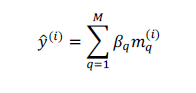




Image from: https://arxiv.org/ftp/arxiv/papers/2008/2008.07715.pdf


With M = set of "m"s  and the optimized "betas":

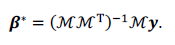

Image from: https://arxiv.org/ftp/arxiv/papers/2008/2008.07715.pdf

There is an scalar factor fz for observable quantities wich takes a set of observable quantities depending the model, in this case this hyperparameters is equal to all the set of observables, fz = 2. 

In [15]:
def betas_matrix(m,y):
    mq=np.array(m) 
    betas= np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(mq),mq )),np.transpose(mq)),y)
    return betas

In [16]:
def betas_model(theta,x,y):
    measure=[]
    for i in range(len(x)):
        m=qcircuit(theta, x[i])
        measure.append(m)
    mq=measure
    betas=betas_matrix(mq,y)
    return betas 

In [18]:
def predictor(theta,x,fz,betas):
    m=qcircuit(theta, x)
    m=m[0:fz]
    matriz_pr=[]
    for i in range(fz):
        pr=m[i,]*betas[i,]
        matriz_pr.append(pr)
    pred=np.sum(matriz_pr)
    return pred

In [20]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

In [22]:
def cost(theta,x,y,fz):
    betas=betas_model(theta,x,y)
    predi=[]
    for i in range(len(x)):
        pred=predictor(theta,x[i],fz,betas)
        predi.append(pred)
    predic=predi
    res=square_loss(y, predic)
    return res

Setting the hyperparameters with 2 qbits, 3 layers, fz=2 and applying Adam optimizer for gettting the values of theta that minimize the cost function:

In [23]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)
num_qubits = 2
num_layers = 3
fz=2
theta_init = 0.01 * np.random.randn(num_layers, num_qubits, 3)
theta = theta_init

In [33]:
print(theta_init)

[[[ 0.00458053 -0.01920125 -0.00139634]
  [-0.0025358  -0.01277273 -0.00166376]]

 [[ 0.0249317   0.02319417  0.00119673]
  [ 0.00232978 -0.01238488  0.00364416]]

 [[-0.00666692 -0.00540131  0.01360436]
  [ 0.00316735  0.00290617 -0.01024155]]]


In [25]:
for it in range(100):
    theta = opt.step(lambda v: cost(v, X, Y, fz), theta)
    betas=betas_model(theta,X,Y)
    predics =[]
    for i in range(len(X)):
      p=predictor(theta,X[i],fz,betas) 
      predics.append(p)
    print("Iter: {:5d} | Cost: {:0.7f} | R2 Score {:0.5f}".format(it + 1, cost(theta, X, Y, fz), r2_score(Y, predics)))


Iter:     1 | Cost: 0.5806689 | R2 Score 0.07354
Iter:     2 | Cost: 0.5764214 | R2 Score 0.08031
Iter:     3 | Cost: 0.5721117 | R2 Score 0.08719
Iter:     4 | Cost: 0.5675343 | R2 Score 0.09449
Iter:     5 | Cost: 0.5625144 | R2 Score 0.10250
Iter:     6 | Cost: 0.5568749 | R2 Score 0.11150
Iter:     7 | Cost: 0.5504153 | R2 Score 0.12181
Iter:     8 | Cost: 0.5428928 | R2 Score 0.13381
Iter:     9 | Cost: 0.5340038 | R2 Score 0.14799
Iter:    10 | Cost: 0.5233616 | R2 Score 0.16497
Iter:    11 | Cost: 0.5104708 | R2 Score 0.18554
Iter:    12 | Cost: 0.4946999 | R2 Score 0.21070
Iter:    13 | Cost: 0.4752655 | R2 Score 0.24171
Iter:    14 | Cost: 0.4512527 | R2 Score 0.28002
Iter:    15 | Cost: 0.4217322 | R2 Score 0.32712
Iter:    16 | Cost: 0.3860728 | R2 Score 0.38402
Iter:    17 | Cost: 0.3445467 | R2 Score 0.45027
Iter:    18 | Cost: 0.2991464 | R2 Score 0.52271
Iter:    19 | Cost: 0.2540345 | R2 Score 0.59469
Iter:    20 | Cost: 0.2146248 | R2 Score 0.65756
Iter:    21 | Cost: 

In [29]:
print(theta, betas)

[[[ 0.00446658  0.35038937  0.00318844]
  [ 0.04186213  0.51468013  0.11580433]]

 [[-0.09881491  0.37601674 -0.11345112]
  [ 0.11979788  0.45441206  0.16257114]]

 [[-0.04242444  0.15716528 -0.02334779]
  [ 0.16209433  0.31816835  0.16307917]]] [-1.93682455  2.64589195]


Finally, we collect the predictions of the trained model for 50 values in the range [−1,1], just like the example of https://pennylane.ai/qml/demos/quantum_neural_net.html


In [26]:
x_pred = np.linspace(-1, 1, 50)
y_pred=[]
for i in range(len(X)):
      new_pred=predictor(theta,x_pred[i],fz,betas) 
      y_pred.append(new_pred)


Finally plotting the results we see that the model (red dots) have been learned from the data (blue dots) and has the similar shape and non linearity characteristic as the original.

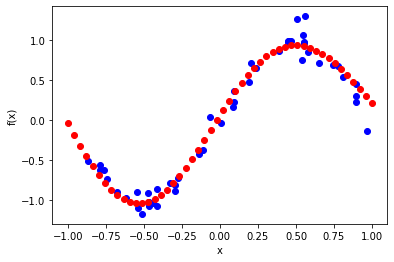

In [31]:
plt.figure()
plt.scatter(X, Y, color="blue")
plt.scatter(x_pred, y_pred, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

